# "Bring back the sun": picture prediction sunny/not sunny

## Preliminaries

In [146]:
import pandas as pd
import numpy as np
import csv
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, learning_curve
from sklearn import preprocessing, metrics, svm, linear_model
from sklearn.metrics import classification_report, confusion_matrix

from featexp import get_univariate_plots, get_trend_stats
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import SelectKBest, chi2
import seaborn as sns; sns.set()


## Completion dataset

In [147]:
df_train = pd.read_csv("training.csv")
df_test = pd.read_csv("testing.csv")
df_add = pd.read_csv("additional_training.csv")
df_conf = pd.read_csv("annotation_confidence.csv")

In [149]:
df_total = pd.concat([df_train, df_add], ignore_index = True)
#df_total.describe()

In [150]:
df_total = df_total.merge(df_conf, on = 'ID')

In [151]:
#df_total.describe()

In [152]:
df_total.columns

Index(['ID', 'CNNs', 'CNNs.1', 'CNNs.2', 'CNNs.3', 'CNNs.4', 'CNNs.5',
       'CNNs.6', 'CNNs.7', 'CNNs.8',
       ...
       'GIST.504', 'GIST.505', 'GIST.506', 'GIST.507', 'GIST.508', 'GIST.509',
       'GIST.510', 'GIST.511', 'prediction', 'confidence'],
      dtype='object', length=4611)

In [153]:
df_total_1 = df_total[((df_total['confidence']==1) & (df_total['prediction']==1))]
df_total_0 = df_total[((df_total['confidence']>0.6) & (df_total['prediction']==0))]

In [154]:
df_total_n = pd.concat([df_total_1, df_total_0], ignore_index = True)

In [257]:
df_total_n.describe()

,ID,CNNs,CNNs.1,CNNs.2,CNNs.3,CNNs.4,CNNs.5,CNNs.6,CNNs.7,CNNs.8,...,GIST.504,GIST.505,GIST.506,GIST.507,GIST.508,GIST.509,GIST.510,GIST.511,prediction,confidence
count,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,...,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000
mean,1291.449832,0.133185,0.212683,0.051565,0.081217,0.067895,0.151778,0.246513,0.187487,0.202021,...,0.017495,0.026466,0.028096,0.019815,0.019312,0.025786,0.027212,0.019763,0.303030,0.893535
std,750.617086,0.323656,0.477366,0.182501,0.264491,0.213849,0.365678,0.417148,0.397181,0.442993,...,0.016425,0.019510,0.019470,0.017244,0.017252,0.018384,0.019007,0.015697,0.459723,0.157734
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.660000
25%,639.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002849,0.011512,0.014455,0.006675,0.004402,0.011013,0.013147,0.007752,0.000000,0.660000
50%,1298.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.013670,0.026058,0.028822,0.016663,0.015815,0.025601,0.027579,0.017682,0.000000,1.000000
75%,1938.000000,0.069485,0.207590,0.000000,0.000000,0.000000,0.000000,0.380220,0.159070,0.175000,...,0.028039,0.038818,0.041009,0.029995,0.030714,0.038226,0.039993,0.029825,1.000000,1.000000
max,2590.000000,3.437700,5.333600,1.627800,3.197300,2.094100,2.766400,3.184500,3.722900,4.092300,...,0.084203,0.131660,0.135410,0.146730,0.095444,0.091376,0.098948,0.084300,1.000000,1.000000


In [155]:
df_total_n.prediction.sum()

450

In [160]:
df_total_n.shape

(1485, 4611)

Thus sunny is 30% (450/1485) in training set, whish is approximate the proportion of sunny data points and the proportion of not sunny data point in the test set. Consequently, the model will be trained on relevant data.

## Pre-processing 

In [157]:
#df_total_n.isnull().sum(axis=0)

In [158]:
df_total_n.replace(0, np.nan, inplace=True)

In [260]:
df_temp = df_total_n.isnull().sum(axis=0)*100/1485

In [162]:
df_temp = df_temp.to_frame().reset_index()

In [261]:
df_temp = df_temp.rename(columns= {0: 'Value', 'index': 'Feature'})
df_temp.index.drop

<bound method Index.drop of Index(['ID', 'CNNs', 'CNNs.1', 'CNNs.2', 'CNNs.3', 'CNNs.4', 'CNNs.5',
       'CNNs.6', 'CNNs.7', 'CNNs.8',
       ...
       'GIST.504', 'GIST.505', 'GIST.506', 'GIST.507', 'GIST.508', 'GIST.509',
       'GIST.510', 'GIST.511', 'prediction', 'confidence'],
      dtype='object', length=4611)>

In [164]:
df_total_n.fillna(0, inplace = True)

In [165]:
df_total_n = df_total_n.reindex(np.random.permutation(df_total_n.index))

In [166]:
df_total_n.columns

Index(['ID', 'CNNs', 'CNNs.1', 'CNNs.2', 'CNNs.3', 'CNNs.4', 'CNNs.5',
       'CNNs.6', 'CNNs.7', 'CNNs.8',
       ...
       'GIST.504', 'GIST.505', 'GIST.506', 'GIST.507', 'GIST.508', 'GIST.509',
       'GIST.510', 'GIST.511', 'prediction', 'confidence'],
      dtype='object', length=4611)

In [167]:
l_drop=['ID', 'confidence']
df_total_n_0 = df_total_n.drop(l_drop, axis = 1)

In [168]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df_total_n_0, df_total_n.prediction,
                                                random_state=42)

In [169]:
df_total_n_0.columns

Index(['CNNs', 'CNNs.1', 'CNNs.2', 'CNNs.3', 'CNNs.4', 'CNNs.5', 'CNNs.6',
       'CNNs.7', 'CNNs.8', 'CNNs.9',
       ...
       'GIST.503', 'GIST.504', 'GIST.505', 'GIST.506', 'GIST.507', 'GIST.508',
       'GIST.509', 'GIST.510', 'GIST.511', 'prediction'],
      dtype='object', length=4609)

## Feature selection

Feature selection via correlation trend method.

                                            Plots for CNNs                                            
                                           Train data plots                                           


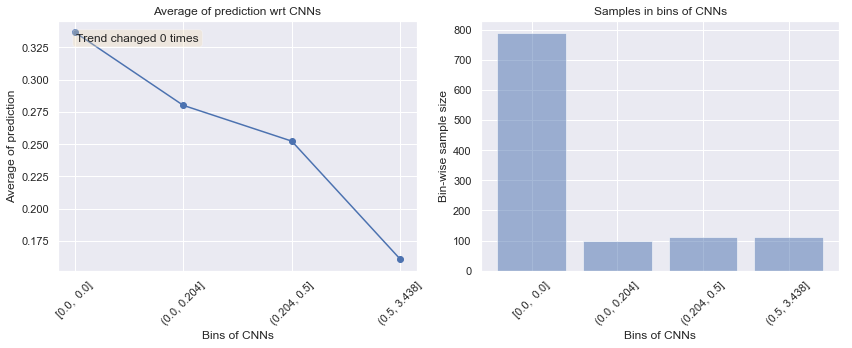

                                           Test data plots                                            


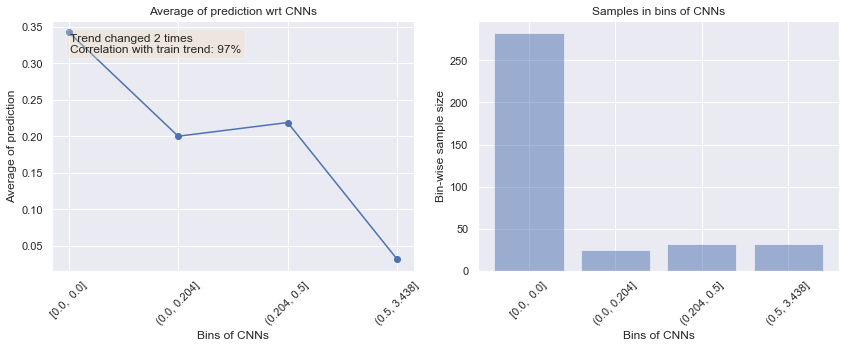

--------------------------------------------------------------------------------------------------------------


                                           Plots for CNNs.1                                           
                                           Train data plots                                           


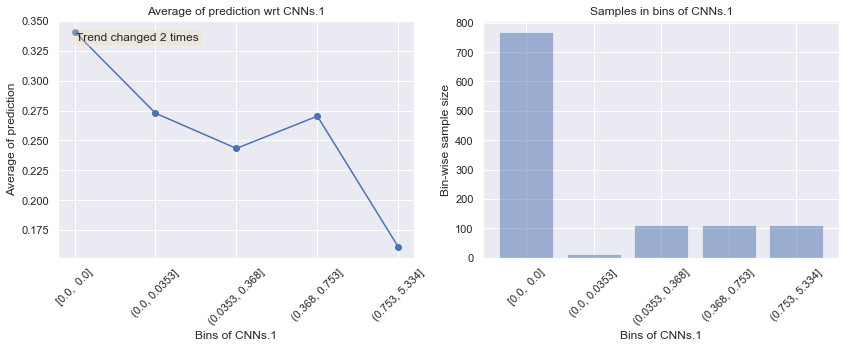

                                           Test data plots                                            


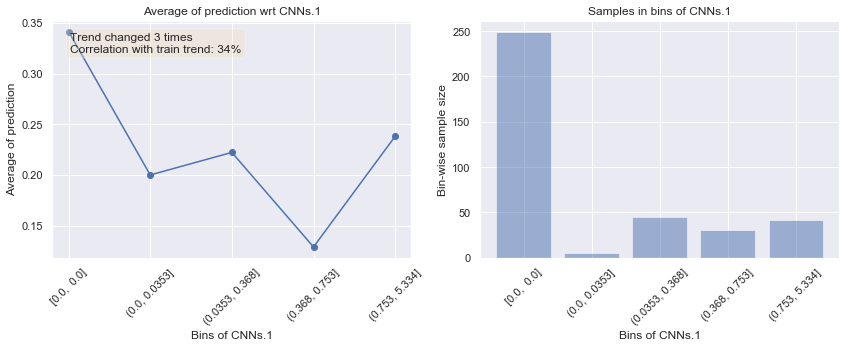

--------------------------------------------------------------------------------------------------------------


                                           Plots for CNNs.2                                           
                                           Train data plots                                           


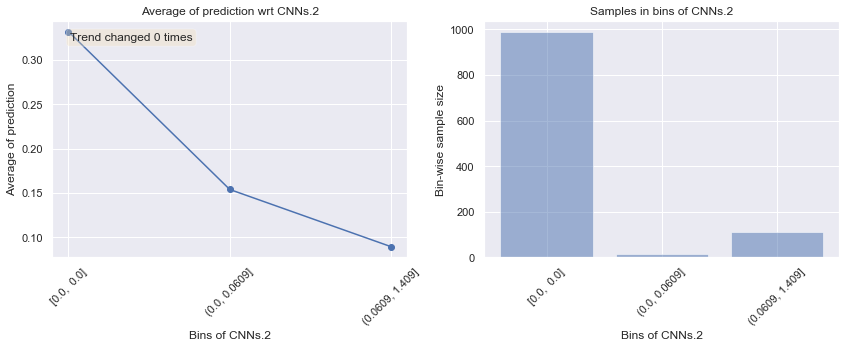

                                           Test data plots                                            


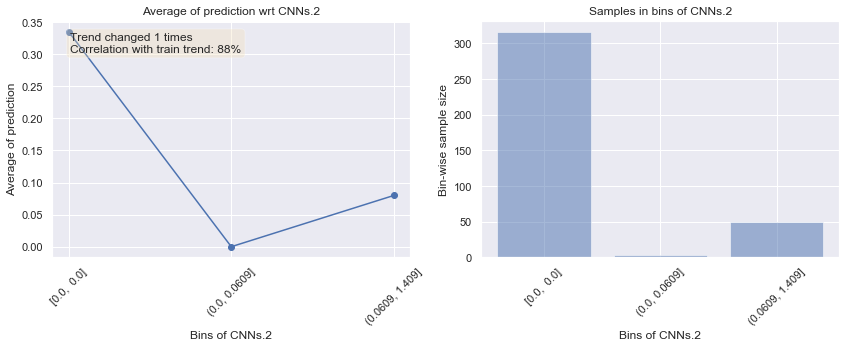

--------------------------------------------------------------------------------------------------------------


                                           Plots for CNNs.3                                           
                                           Train data plots                                           


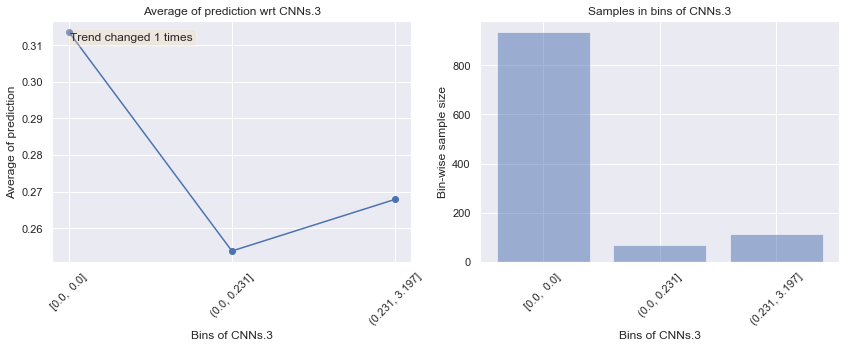

                                           Test data plots                                            


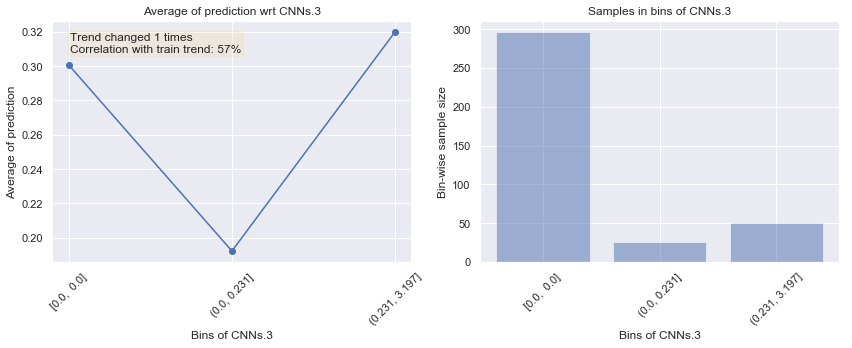

--------------------------------------------------------------------------------------------------------------


                                           Plots for CNNs.4                                           
                                           Train data plots                                           


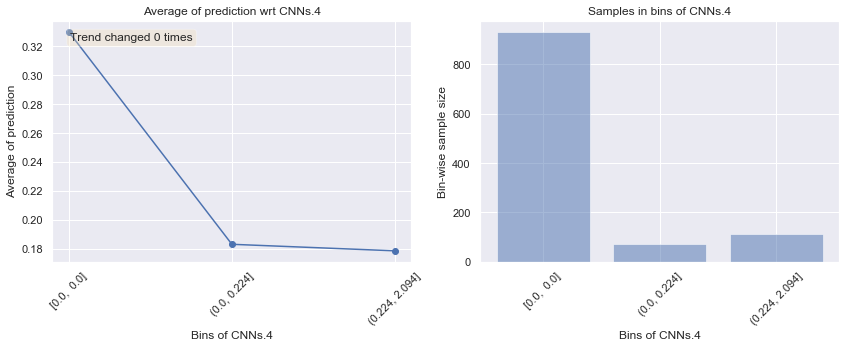

                                           Test data plots                                            


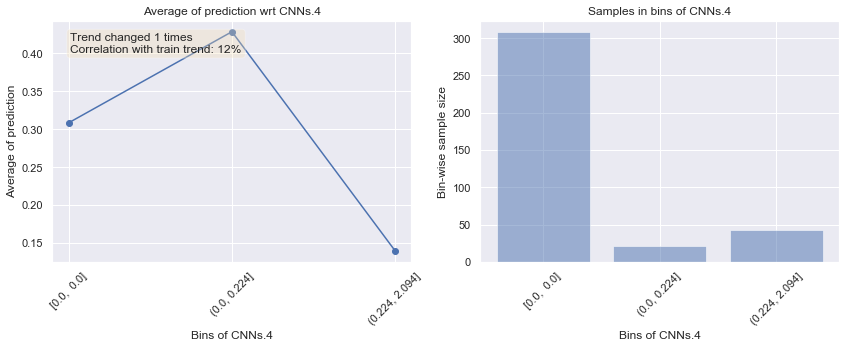

--------------------------------------------------------------------------------------------------------------


                                           Plots for CNNs.5                                           
                                           Train data plots                                           


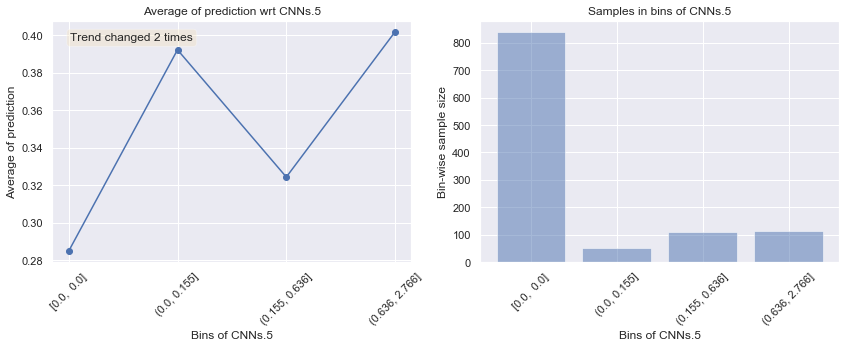

                                           Test data plots                                            


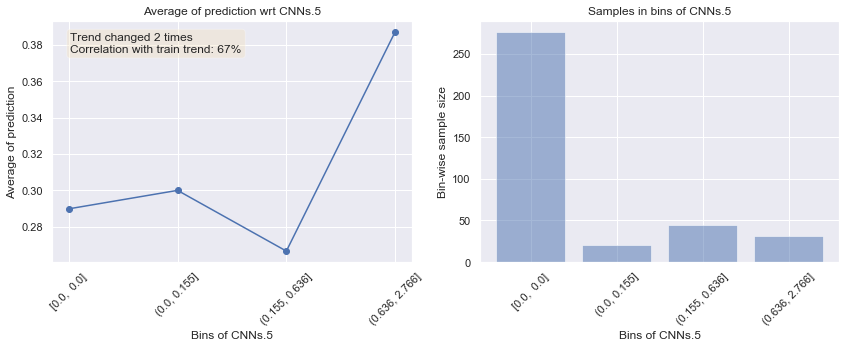

--------------------------------------------------------------------------------------------------------------


                                           Plots for CNNs.6                                           
                                           Train data plots                                           


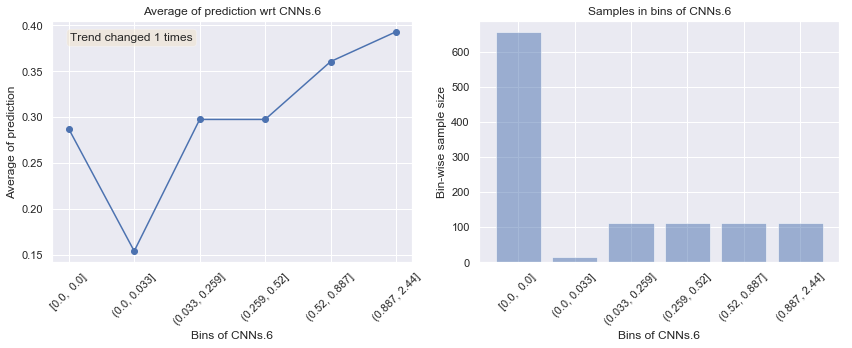

                                           Test data plots                                            


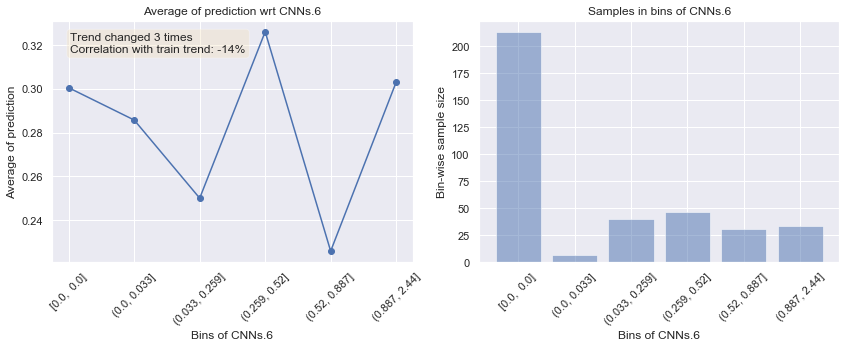

--------------------------------------------------------------------------------------------------------------


                                           Plots for CNNs.7                                           
                                           Train data plots                                           


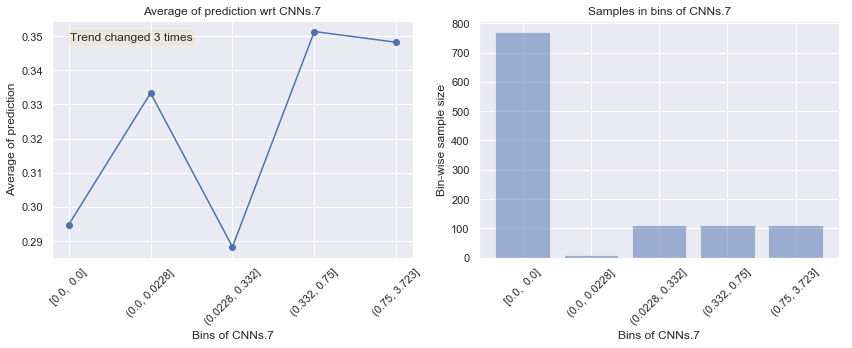

                                           Test data plots                                            


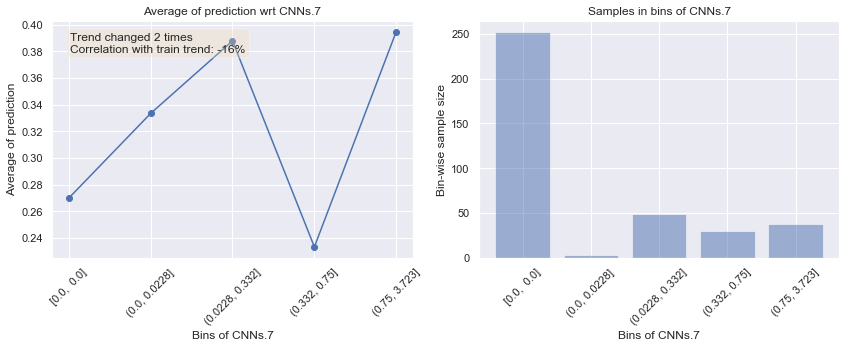

--------------------------------------------------------------------------------------------------------------


                                           Plots for CNNs.8                                           
                                           Train data plots                                           


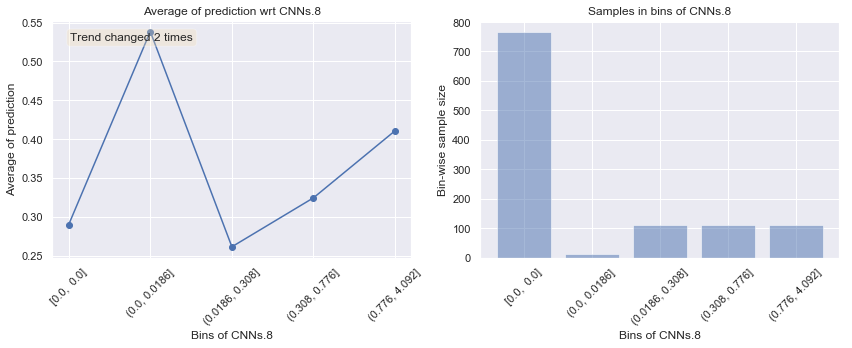

                                           Test data plots                                            


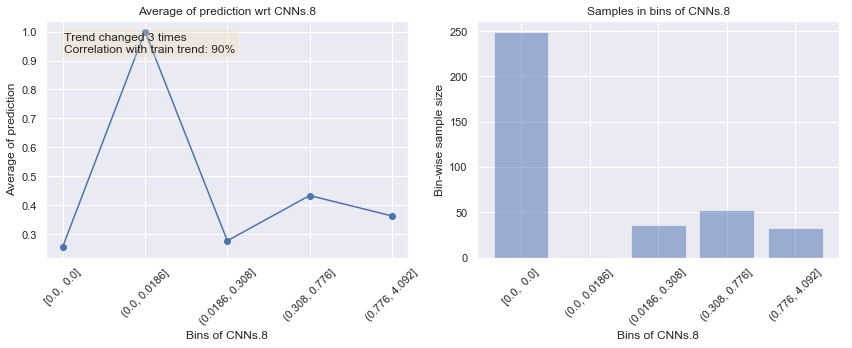

--------------------------------------------------------------------------------------------------------------


                                           Plots for CNNs.9                                           
                                           Train data plots                                           


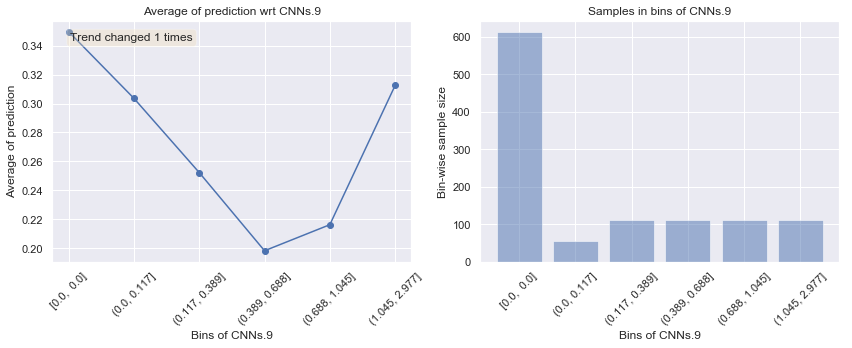

                                           Test data plots                                            


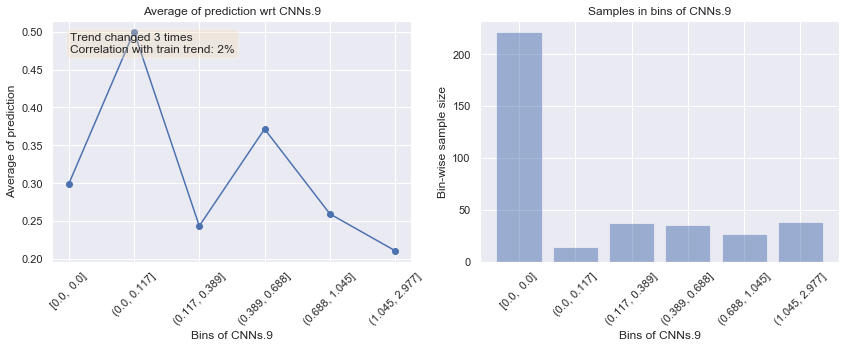

--------------------------------------------------------------------------------------------------------------




In [170]:
# plots univariate plots of first 10 columns in data_train
get_univariate_plots(data=Xtrain, target_col='prediction', features_list=Xtrain.columns[:10], data_test=Xtest)

Calculate trend changes and correlation between features from training and test data

In [171]:
stats = get_trend_stats(data=Xtrain, target_col='prediction', data_test=Xtest)

Returning stats for all numeric features


In [276]:
stats[:5]

,Feature,Trend_changes,Trend_changes_test,Trend_correlation
0,CNNs,0,2,0.976335
1,CNNs.1,2,3,0.345182
2,CNNs.2,0,1,0.882308
3,CNNs.3,1,1,0.572839
4,CNNs.4,0,1,0.123071


In [377]:
def get_not_noise(stats, noise_threshold):
    not_noise = []
    not_noise = list(stats[stats['Trend_correlation']>noise_threshold]['Feature'])
    #not_noise = [col for col in not_noise if 'CNN' in col]
    return not_noise

def update_feature_set(df, f):
    return df[f]

feature_set_1 = get_not_noise(stats, 0.85)
len(feature_set_1)

1164

In [284]:
cnn = [col for col in feature_set_1 if 'CNN' in col]
gist = [col for col in feature_set_1 if 'GIST' in col]
print("Feature selection via correlation trend: CNN features are", len(cnn), "GIST features are ", len(gist))

Feature selection via correlation trend: CNN features are 1075 GIST features are  89


Feature selection via Chi2 method

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


1191

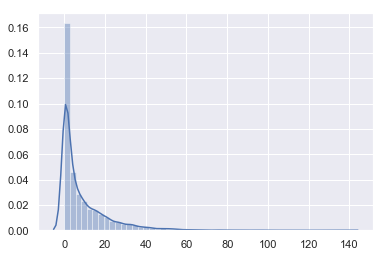

In [388]:
X_chi = Xtrain.drop('prediction', axis = 1)
feature_set_3 = []
    
def get_features_chi(X_chi, ytrain, threshold):
    chi, pvalue = chi2(X_chi, ytrain)
    c = []
    f_ = []
    for i, v in enumerate(chi):
        if v > threshold:
            c.append([v, i])
    c.sort(reverse = True)
    for i in range(len(c)):
        f_.append(Xtrain.columns[c[i][1]])
    return f_
sns.distplot(chi)
feature_set_3 = get_features_chi(X_chi, ytrain, 12)
len(feature_set_3)

In [279]:
cnn = [col for col in feature_set_3 if 'CNN' in col]
gist = [col for col in feature_set_3 if 'GIST' in col]
print("Feature selection via Chi2: CNN features are ", len(cnn), ". GIST features are ", len(gist))

Feature selection via Chi2: CNN features are  1191 . GIST features are  0


# Data normalisation

The attemp to use scaling decreased accuracy more than 3%. Do not apply in final model

In [75]:
#my_scaler = preprocessing.StandardScaler(copy = True, with_mean=True, with_std=True)
#Xtrain_scaled = pd.DataFrame(my_scaler.fit_transform(Xtrain.values))
#Xtest_scaled = pd.DataFrame(my_scaler.fit_transform(Xtest.values))
#Xtrain_scaled.columns = Xtrain.columns
#Xtest_scaled.columns = Xtest.columns

### Functions for training and test data

In [ ]:
def train_model(X_train, y_train, C, gamma, model):
    if model[0] == "svm":
        clf = svm.SVC(kernel = model[1], C = C, gamma = gamma,  probability = True)
    elif model[0] == "lr":
        #If the option chosen is ‘ovr’, then a binary problem is fit for each label.
        #Algorithm to use in the optimization problem. For small datasets, ‘liblinear’ is a good choice
        clf = LogisticRegression(C = C, multi_class = "warn", solver = 'warn', class_weight = 'balanced', verbose = 0).fit(X_train, y_train)
    clf.fit(X_train, y_train)
    
    return clf

def test_model(clf, X_test):
    return clf.predict(X_test)

# Cross-validation

In [379]:
C_ = [0.001, 0.01, 1, 10]
G_ = [0.001, 0.01, 0.1, 1]
score = []
d = {}
mean = 0
std = 0

for c in C_:
    d.update({c: []})
    for g in G_:
        print("Training with C=", c, ', g=', g)
        clf = train_model(X, y, c, g, ['svm', "rbf"])
        print('Start CV for C = ', c, ', g = ', g)
        score = cross_val_score(clf, X, y, cv = 10)
        d[c].append([g, score])
        mean = np.round(np.mean(score), 4)
        std = np.round(np.std(score), 4)
        print('Mean: ', mean, ". Std: ", std, 'CV=', score)
        score=[] 

Training with C= 0.001 , g= 0.001
Start CV for C =  0.001 , g =  0.001
Mean:  0.6945 . Std:  0.0013 CV= [0.69642857 0.69642857 0.69642857 0.69369369 0.69369369 0.69369369
 0.69369369 0.69369369 0.69369369 0.69369369]
Training with C= 0.001 , g= 0.01
Start CV for C =  0.001 , g =  0.01
Mean:  0.6945 . Std:  0.0013 CV= [0.69642857 0.69642857 0.69642857 0.69369369 0.69369369 0.69369369
 0.69369369 0.69369369 0.69369369 0.69369369]
Training with C= 0.001 , g= 0.1
Start CV for C =  0.001 , g =  0.1
Mean:  0.6945 . Std:  0.0013 CV= [0.69642857 0.69642857 0.69642857 0.69369369 0.69369369 0.69369369
 0.69369369 0.69369369 0.69369369 0.69369369]
Training with C= 0.001 , g= 1
Start CV for C =  0.001 , g =  1
Mean:  0.6945 . Std:  0.0013 CV= [0.69642857 0.69642857 0.69642857 0.69369369 0.69369369 0.69369369
 0.69369369 0.69369369 0.69369369 0.69369369]
Training with C= 0.01 , g= 0.001
Start CV for C =  0.01 , g =  0.001
Mean:  0.6945 . Std:  0.0013 CV= [0.69642857 0.69642857 0.69642857 0.69369369

## Feature selection performance

In [ ]:
s = [0.0, 0.5, 0.6, 0.7, 0.8, 0.82, 0.83, 0.85, 0.86, 0.87, 0.9]
f = 0
l = 0
acc = {}
for i in s:
    f = get_not_noise(stats, i)
    l = len(f)
    print(l)
    clf = train_model(update_feature_set(Xtrain, f), y, 1, 0.01, ['svm', "rbf"])
    clf_predictions = test_model(clf, update_feature_set(Xtest, f))
    acc[l]=metrics.accuracy_score(ytest, clf_predictions)

In [ ]:
s = [0, 1, 5, 10, 12, 15, 17, 20, 25]
f = 0
l = 0
acc2 = {}
for i in s:
    f = get_features_chi(X_chi, ytrain, i)
    l = len(f)
    print(l)
    clf = train_model(update_feature_set(Xtrain, f), ytrain, 1, 0.01, ['svm', "rbf"])
    clf_predictions = test_model(clf, update_feature_set(Xtest, f))
    acc2[l]=metrics.accuracy_score(ytest, clf_predictions)

In [334]:
df_temp2 = pd.DataFrame.from_dict(acc2, orient = 'index', columns = ['Chi-squared'])
df_temp2

,Chi-squared
4608,0.704301
3154,0.704301
2032,0.717742
1371,0.766129
1191,0.766129
958,0.763441
814,0.760753
648,0.755376
446,0.776882


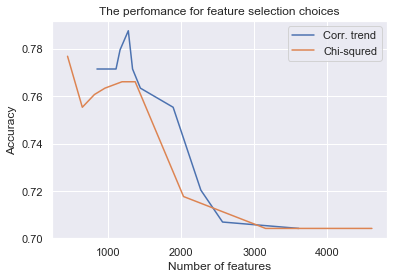

In [308]:
ax = plt.subplot(111)

plt.plot(list(acc.keys()), list(acc.values()), label = 'Corr. trend')
plt.plot(list(acc2.keys()), list(acc2.values()), label = "Chi-squred")
plt.title('The perfomance for feature selection choices')
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
ax.legend()
plt.show()

## Experiment with different kernels

In [375]:
kernel = ['linear', 'sigmoid', 'rbf']
acc3 = {}
for i in kernel:
    clf = train_model(update_feature_set(Xtrain, feature_set_1), y, 1, 0.01, ['svm', i])
    clf_predictions = test_model(clf, update_feature_set(Xtest, feature_set_1))
    acc3[i] = metrics.accuracy_score(ytest, clf_predictions) * 100 


In [376]:
df_temp3 = pd.DataFrame.from_dict(acc3, orient = 'index', columns = ['Accuracy'])
df_temp3

,Accuracy
linear,72.580645
sigmoid,77.150538
rbf,77.956989


## Update data sets with new feature set

In [381]:
X = update_feature_set(Xtrain, feature_set_1)
y = ytrain

X = pd.concat([X, X], ignore_index = True)
y = pd.concat([y, y], ignore_index = True)

# Train and test model

In [382]:
clf = train_model(X, y, 1, 0.01, ['svm', "rbf"])
clf_predictions = test_model(clf, update_feature_set(Xtest, feature_set_1))
print("Accuracy: {}%".format(metrics.accuracy_score(ytest, clf_predictions) * 100 ))
print(classification_report(ytest, clf_predictions))

Accuracy: 80.64516129032258%
              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87       262
         1.0       0.69      0.62      0.65       110

   micro avg       0.81      0.81      0.81       372
   macro avg       0.77      0.75      0.76       372
weighted avg       0.80      0.81      0.80       372



# Learning curve

Automatically created module for IPython interactive environment


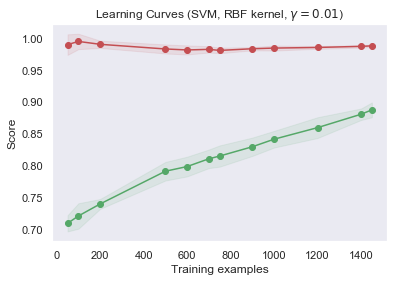

In [391]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.utils import shuffle

train_sizes = [50, 100, 200, 500, 600, 700, 750, 900, 1000, 1200, 1400, 1450]

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=train_sizes):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    return plt

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.01$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
estimator = clf
#SVC(C = 1, gamma=0.001)
plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=4)
plt.show()

# Prepare results for Kaggle

In [185]:
def create_result_file(df_test, clf_predictions):
    result = []
    for i, v in enumerate(df_test["ID"]):
        result.append([v, clf_predictions[i]])

    with open('result.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        csvFile.write('ID,prediction' + '\n')
        for line in result:
            csvFile.write(str(line[0]) + ','+ str(int(line[1])) + '\n')
    csvFile.close()

In [322]:
clf_predictions = test_model(clf, update_feature_set(df_test, feature_set_1))
create_result_file(df_test, clf_predictions)